In [1]:
import scanpy as sc
import pandas as pd
import pickle
import numpy as np
import graph_tool.all as gt
%matplotlib inline
%pylab

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import anndata
adata=sc.read('adata_10x/adata_sc_10x.h5ad')
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo
cell_annotation= pd.read_table('../sc_mixology/data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

In [3]:
g = pickle.load( open( "adata_10x/10x_graph_g.pkl", "rb" ))

In [4]:
state= gt.minimize_nested_blockmodel_dl(g,deg_corr=False)

... storing 'cell_line' as categorical


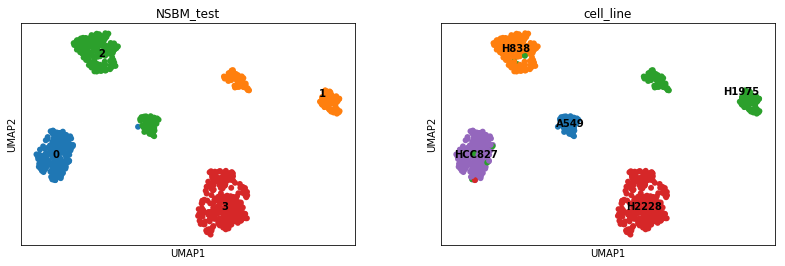

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,1,0,4,1,188
1,0,0,127,0,0
2,61,176,7,0,0
3,0,0,0,295,0


In [5]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [33]:
state1=state.copy()

# multiflip

In [34]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
stateM = state.copy(bs=bs, sampling=True)
stateM.multiflip_mcmc_sweep(niter=10000)

(-2.2557909577458073, 7582222, 122368)

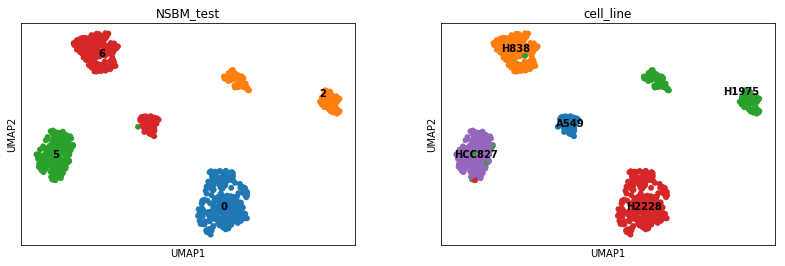

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,0,295,0
2,0,0,127,0,0
5,1,0,4,1,188
6,61,176,7,0,0


In [35]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(stateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [38]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=100000,epsilon=0.001,gibbs=False,multiflip=True,force_niter=None, mcmc_args=dict(niter=10))
estateM

<NestedBlockState object, with base <BlockState object with 61 blocks (61 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f2ea90ab310>, at 0x7f2ea001cf50>, and 5 levels of sizes [(860, 61), (61, 13), (13, 4), (4, 2), (2, 1)] at 0x7f2ea007e4d0>

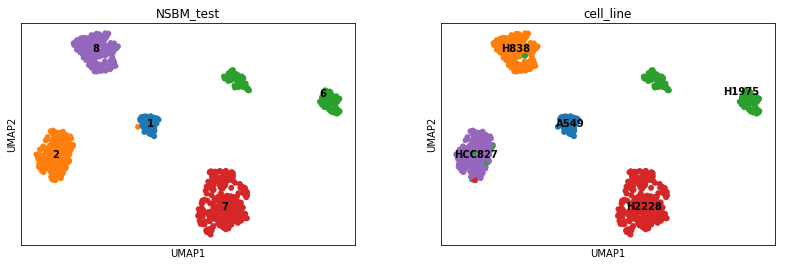

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,61,0,0,0,0
2,1,0,4,1,188
6,0,0,127,0,0
7,0,0,0,295,0
8,0,176,7,0,0


In [40]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [46]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=3,max_niter=100000,epsilon=0.001,gibbs=False,multiflip=True,force_niter=None, mcmc_args=dict(niter=10))
estateM

<NestedBlockState object, with base <BlockState object with 79 blocks (68 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f2ea90ab310>, at 0x7f2ea03e7fd0>, and 10 levels of sizes [(860, 68), (68, 14), (14, 5), (5, 3), (3, 2), (2, 2), (2, 1), (1, 1), (1, 1), (1, 1)] at 0x7f2ea03e7490>

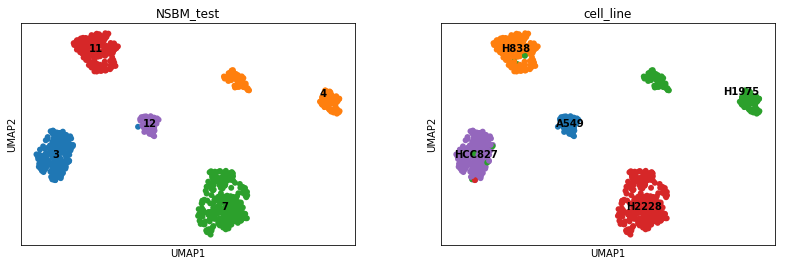

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
3,1,0,4,1,188
4,0,0,127,0,0
7,0,0,0,295,0
11,0,176,7,0,0
12,61,0,0,0,0


In [47]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

# sweep

In [29]:
bs = state1.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
stateS = state1.copy(bs=bs, sampling=True)
stateS.multiflip_mcmc_sweep(niter=1000, psplit=0.8)

(22.240222979362954, 855384, 12602)

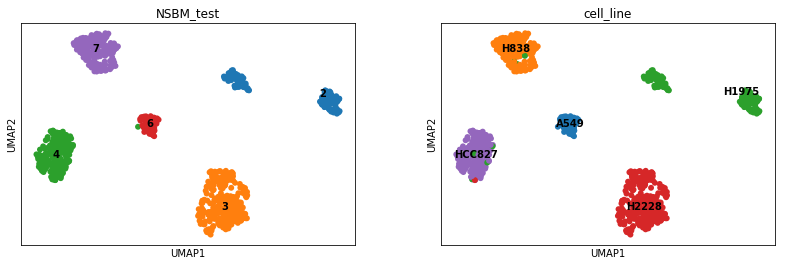

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
2,0,0,127,0,0
3,0,0,0,295,0
4,1,0,4,1,188
6,61,0,0,0,0
7,0,176,7,0,0


In [30]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(stateS.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [37]:
bs = state1.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
a=time.time()
estateS = stateS.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estateS,wait=1000,nbreaks=2,max_niter=100000,epsilon=0.001,multiflip=True, mcmc_args=dict(niter=10,psplit=0.8))
b=time.time()
c=b-a
print(c)

estateS


362.34843730926514


<NestedBlockState object, with base <BlockState object with 78 blocks (71 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f77d32289d0>, at 0x7f77d083c390>, and 10 levels of sizes [(860, 71), (71, 16), (16, 6), (6, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f77b17fd9d0>

In [38]:
estateS

<NestedBlockState object, with base <BlockState object with 78 blocks (71 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f77d32289d0>, at 0x7f77d083c390>, and 10 levels of sizes [(860, 71), (71, 16), (16, 6), (6, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f77b17fd9d0>

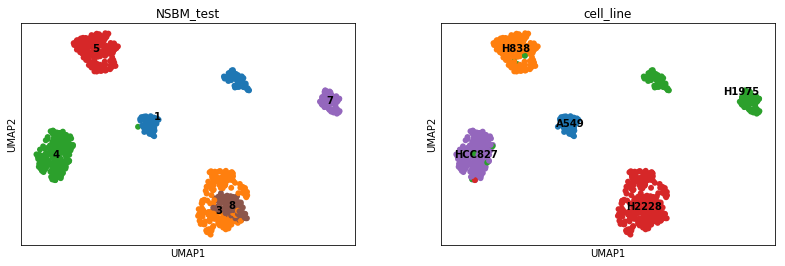

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,61,0,56,0,0
3,0,0,0,196,0
4,1,0,4,1,188
5,0,176,7,0,0
7,0,0,71,0,0
8,0,0,0,99,0


In [39]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateS.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

# deg corr true

In [57]:
state= gt.minimize_nested_blockmodel_dl(g)
state

In [60]:
state2=state.copy()

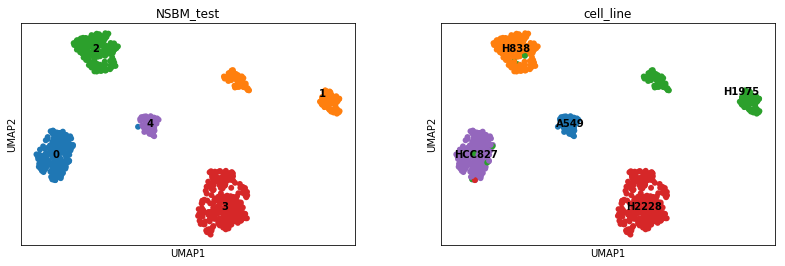

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,1,0,4,1,188
1,0,0,127,0,0
2,0,176,7,0,0
3,0,0,0,295,0
4,61,0,0,0,0


In [59]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [61]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
stateM = state.copy(bs=bs, sampling=True)
stateM.multiflip_mcmc_sweep(niter=10000)
stateM

<NestedBlockState object, with base <BlockState object with 63 blocks (56 nonempty), degree-corrected, for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f2ea90ab310>, at 0x7f2e83f9e550>, and 10 levels of sizes [(860, 56), (56, 14), (14, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f2e83f941d0>

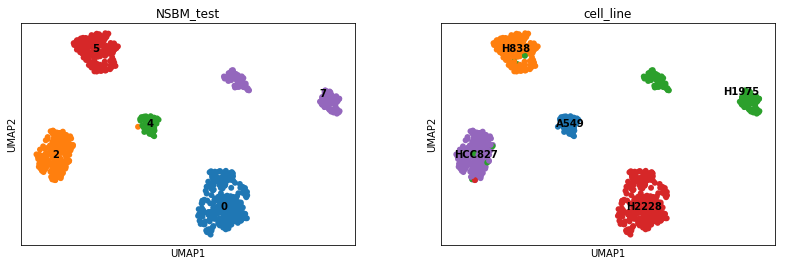

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,0,295,0
2,1,0,4,1,188
4,61,0,0,0,0
5,0,176,7,0,0
7,0,0,127,0,0


In [62]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(stateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [67]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=1000000,epsilon=0.001,multiflip=True,force_niter=None, mcmc_args=dict(niter=10))
estateM

<NestedBlockState object, with base <BlockState object with 69 blocks (60 nonempty), degree-corrected, for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f2ea90ab310>, at 0x7f2ea13b0590>, and 10 levels of sizes [(860, 60), (60, 15), (15, 6), (6, 4), (4, 3), (3, 2), (2, 2), (2, 2), (2, 1), (1, 1)] at 0x7f2ea13b0dd0>

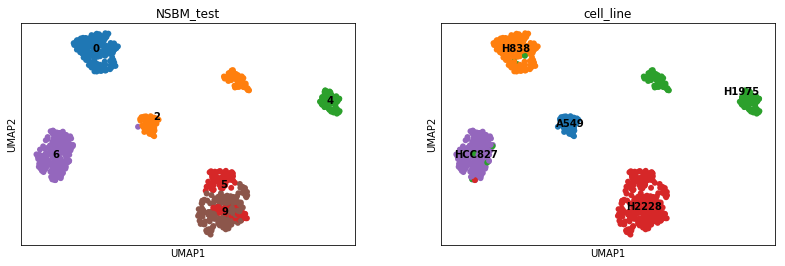

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,176,7,0,0
2,61,0,56,0,0
4,0,0,71,0,0
5,0,0,0,107,0
6,1,0,4,1,188
9,0,0,0,188,0


In [68]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

# without rank gene

In [69]:
import anndata
adata=sc.read('adata_10x/adata_sc_10x.h5ad')
cell_annotation= pd.read_table('../sc_mixology/data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

In [70]:
state= gt.minimize_nested_blockmodel_dl(g,deg_corr=False)
state

<NestedBlockState object, with base <BlockState object with 67 blocks (67 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f2ea90ab310>, at 0x7f2ea0261d90>, and 5 levels of sizes [(860, 67), (67, 12), (12, 4), (4, 2), (2, 1)] at 0x7f2ea040c250>

... storing 'cell_line' as categorical


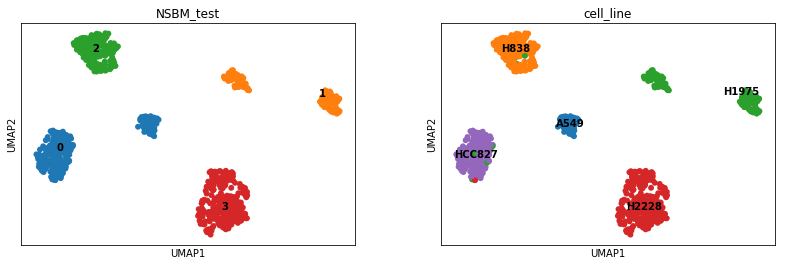

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,62,0,4,1,188
1,0,0,127,0,0
2,0,176,7,0,0
3,0,0,0,295,0


In [71]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [72]:
state3=state.copy()

In [73]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
stateM = state.copy(bs=bs, sampling=True)
stateM.multiflip_mcmc_sweep(niter=10000)
stateM

<NestedBlockState object, with base <BlockState object with 75 blocks (67 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f2ea90ab310>, at 0x7f2ea0422cd0>, and 10 levels of sizes [(860, 67), (67, 15), (15, 5), (5, 3), (3, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f2ea0422c90>

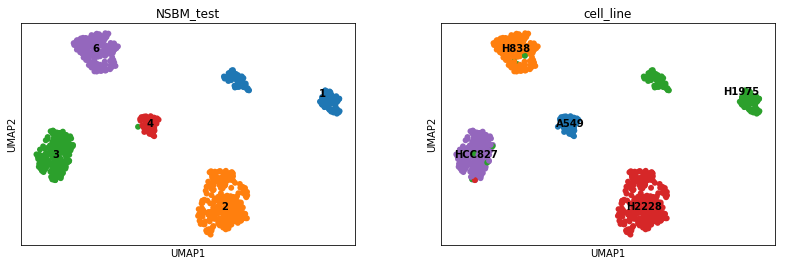

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,0,0,127,0,0
2,0,0,0,295,0
3,1,0,4,1,188
4,61,0,0,0,0
6,0,176,7,0,0


In [74]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(stateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [75]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=1000000,epsilon=0.001,multiflip=True,force_niter=None, mcmc_args=dict(niter=10))
estateM

<NestedBlockState object, with base <BlockState object with 77 blocks (68 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f2ea90ab310>, at 0x7f2e542e0950>, and 10 levels of sizes [(860, 68), (68, 14), (14, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f2e542e0c90>

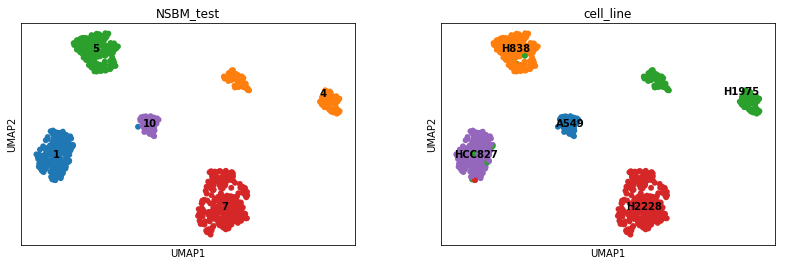

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,1,0,4,1,188
4,0,0,127,0,0
5,0,176,7,0,0
7,0,0,0,295,0
10,61,0,0,0,0


In [76]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)